## Планы:
1. Гауссианы?
2. Нейронки из статей
3. Автоэнкодер?

In [675]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# strainforfard peaks search
import plotly.graph_objects as go
from scipy.signal import find_peaks, savgol_filter

# peaks search by gauss decomposition
# import gausspy
# import gausspy.gp as gp
# import pickle

from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier


In [44]:
# !pip install plotly
# !pip install pandas
# !conda install pytorch torchvision torchaudio -c pytorch -y
# !pip install -U scikit-learn

## Data loading/proccessing

Загрузка данных

In [13]:
# # для работы в колабе 
# from google.colab import drive
# drive.mount('/content/drive')

In [64]:
# ga_file = "/content/drive/MyDrive/AIRI/RamanSpectra/ga_2_3_5_6.csv"
# fg_file = "/content/drive/MyDrive/AIRI/RamanSpectra/fg_1-5_7-11.csv"
ga_file = "dataSrc/ga_2_3_5_6.csv"
fg_file = "dataSrc/fg_1-5_7-11.csv"
data_ga = pd.read_csv(ga_file, sep=";")
print(f"data with GA samples shape: {data_ga.shape}")
data_fg = pd.read_csv(fg_file, sep=";")
print(f"data with FG samples shape: {data_fg.shape}")

data with GA samples shape: (89, 995)
data with FG samples shape: (569, 995)


In [65]:
y_fg = data_fg['class'].values
X_fg = data_fg.drop(columns=['class'])
print(f"shapes of X and y of FG samples respectively is: {X_fg.shape}, {y_fg.shape}")

y_ga = data_ga['class'].values
X_ga = data_ga.drop(columns=['class'])
print(f"shapes of X and y of GA samples respectively is: {X_ga.shape}, {y_ga.shape}")

shapes of X and y of FG samples respectively is: (569, 994), (569,)
shapes of X and y of GA samples respectively is: (89, 994), (89,)


Наведем красоту:

In [66]:
print(f"old fg classes: {set(y_fg)}")
for index, element in enumerate(set(y_fg)):
    y_fg[y_fg == element] = index
print(f"new fg classes: {set(y_fg)}\n")

print(f"old ga classes: {set(y_ga)}")
for index, element in enumerate(set(y_ga)):
    y_ga[y_ga == element] = index + len(set(y_fg))
print(f"new ga classes: {set(y_ga)}")

old fg classes: {1, 2, 3, 4, 5, 7, 8, 9, 10, 11}
new fg classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

old ga classes: {2, 3, 5, 6}
new ga classes: {10, 11, 12, 13}


Добавим к target(то есть, к y_fg и y_ga) группы:

In [67]:
group1 = [0, 1, 2, 3, 4]
group2 = [5, 6, 7, 8, 9]
group3 = [10, 11]
group4 = [12, 13]
groups = [group1, group2, group3, group4]

def add_group(y, groups, add=0):
    new_y = np.zeros((y.shape[0], 2))
    new_y[:, 1] = y
    for group_num, group in enumerate(groups):
        for class_num in group:
            new_y[y==class_num] = np.array([group_num + add, class_num])
    return new_y

y_ga = add_group(y_ga, (group3, group4), add=2)
y_fg = add_group(y_fg, (group1, group2))
print(f"Now, shapes of y_fg and ga is respectively: {y_ga.shape}, {y_fg.shape}")

Now, shapes of y_fg and ga is respectively: (89, 2), (569, 2)


Соединим две базы данных друг с другом: 

In [68]:
y = np.concatenate((y_fg, y_ga), axis=0)
X = np.concatenate((X_fg, X_ga), axis=0)
X = X.reshape(X.shape[0], 1, -1)
print(f"shapes of X and y is respectively: {X.shape}, {y.shape}")

shapes of X and y is respectively: (658, 1, 994), (658, 2)


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [70]:
data_loader_train = DataLoader(tuple(zip(torch.tensor(X_train).float(), torch.tensor(y_train).long())), 
                                      batch_size=16, 
                                      shuffle=True)
data_loader_test = DataLoader(tuple(zip(torch.tensor(X_test).float(), torch.tensor(y_test).long())), 
                                     batch_size=16, 
                                     shuffle=False)

Нарисуем один из спектров:

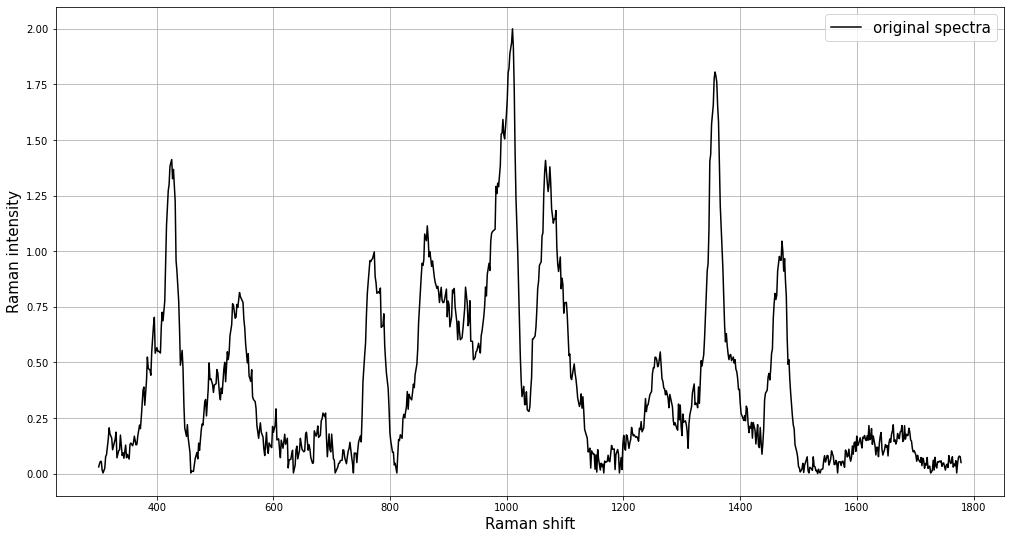

In [698]:
plt.figure(figsize=(17, 9))
plt.plot(
    data_fg.columns[1:-1].astype('float'), 
    data_fg.values[:, 1:-1][-1],
    c='black',
    label='original spectra'
)
# plt.plot(
#     data_fg.columns[1:-1].astype('float'), 
#     savgol_filter(data_fg.values[:, 1:-1][-1].reshape(-1), 35, 2),
#     c='red',
#     linestyle='--',
#     label='smooth spectra', 
    
# )

plt.grid()
plt.ylabel("Raman intensity", fontsize=15)
plt.xlabel("Raman shift", fontsize=15)
plt.legend(fontsize=15)
None

### Обработка спектра с помощью сглаживания

In [712]:
import plotly.graph_objects as go
import pandas as pd
from scipy.signal import find_peaks

def get_picks(y, x, filter_width=25, pol_degree=2, distance=40, height=0.1, width=10, visualize=False):
    
    indices = find_peaks(savgol_filter(y, filter_width, pol_degree), 
                         distance=distance, 
                         height=height,
                         width=width,
    #                      plateau_size=[1,30]
                        )
    indices = indices[0]
    
    if visualize:
        fig = go.Figure()
        # fig.figsize = (17, 10)
        fig.update_layout(
            margin=dict(l=30, r=30, t=20, b=20),
            paper_bgcolor="LightSteelBlue"
        )
        fig.add_trace(
            go.Scatter(
                y=y,
                x=x,
                name='Original Plot'
            )
        )

        fig.add_trace(go.Scatter(
            x=x[indices],
            y=[savgol_filter(y, filter_width, pol_degree)[j] for j in indices],
        #     y=[data_fg.values[:, 1:-1][-1][j] for j in indices],
            mode='markers',
            marker=dict(
                size=8,
                color='red',
                symbol='cross'
            ),
            name='Detected Peaks'
        ))


        fig.add_trace(go.Scatter(
        #     x=data_fg.values[:, 1:-1][-1],
            y=savgol_filter(y, filter_width, pol_degree),
            x=x,
        #     mode='markers',
        #     marker=dict(
        #         size=6,
        #         color='mediumpurple',
        #         symbol='triangle-up'
        #     ),
            name='Savitzky-Golay'
        ))

        fig.show()
    return x[indices]

get_picks(
    y=X[572].reshape(-1), 
    x=data_fg.columns[1:-1].astype('float'),
    visualize=True, 
    height=0.15,
    width=5,
    distance=20
)
# get_picks(
#     y=data_fg.values[:, 1:-1][200], 
#     x=data_fg.columns[1:-1].astype('float'),
#     visualize=True
# )

Float64Index([1471.62358, 1359.88945, 1081.29901,  977.01382,  898.05503,
               774.40259,  543.48539,  416.85337],
             dtype='float64')

In [628]:
len(set([' '.join(str(j) for j in list(i)) for i in data_peaks]))

631

In [651]:
data_peaks = []
for y_i in X:
#     print(x_i.reshape(-1).shape, y_i)
    peaks = get_picks(
        y=y_i.reshape(-1), 
        x=data_fg.columns[1:-1].astype('float'),
#         visualize=True,
        width=5,
        height=0.15,
        distance=20,
    )
    data_peaks.append(list(peaks.values))
print(len(data_peaks))

658


In [652]:
min_size = 100
min_peaks = []
min_index = 0
max_size = 0
max_peaks = []
max_index = 0
for index, peaks in enumerate(data_peaks):
    if min_size > len(peaks):
        min_size = len(peaks)
        min_peaks = peaks
        min_index = index
    if max_size < len(peaks):
        max_size = len(peaks)
        max_peaks = peaks
        max_index = index

print(f"""min_size = {min_size}, min_index = {min_index}, min_peaks = {min_peaks},
max_size = {max_size}, max_index = {max_index}, max_peaks = {max_peaks}""")

min_size = 8, min_index = 572, min_peaks = [1471.62358, 1359.88945, 1081.29901, 977.01382, 898.05503, 774.40259, 543.48539, 416.85337],
max_size = 23, max_index = 645, max_peaks = [1759.15275, 1692.11227, 1636.9901, 1593.78623, 1546.113, 1468.64401, 1404.5831, 1359.88945, 1255.60426, 1117.05393, 1066.40113, 1003.83001, 920.40186, 860.81032, 795.25963, 738.64767, 683.5255, 649.26037, 609.03608, 540.50581, 501.77131, 419.83295, 388.54739]


In [654]:
# data_peaks

In [656]:
def cut_peaks(data, min_size):
    new_data = []
    for example in data:
#         print(example)
        new_data.append(example[:min_size])
    return np.array(new_data)

data_cut = cut_peaks(data_peaks, min_size)
print(data_cut.shape)


def fill_peaks(data, max_size):
    new_data = []
    for example in data:
#         print(example)
        new_data.append(example+[0 for i in range(max_size - len(example))])
    return np.array(new_data)

data_filled = fill_peaks(data_peaks, max_size)
print(data_filled.shape)

(658, 8)
(658, 23)


In [657]:
np.savetxt("peaks_cut.csv", data_cut, delimiter=',')
np.savetxt("peaks_filled.csv", data_filled, delimiter=',')

### Применение методов ml

In [664]:
# !pip install xgboost
# !pip install OpenMP

In [667]:
# import xgboost as xgb
# import time

In [671]:
# y

In [702]:
def random_forest_train(data, y, num_features, label='data_cut dataset', class_type='group'):
#     print(data.shape, y.shape)
    if class_type == 'group':
        class_type = 0
    elif class_type == 'class':
        class_type = 1
    else:
        raise Exception("class_type may be equal only 'group' or 'class'")
    exrt_crystal_system = ExtraTreesClassifier(
        n_estimators=1000, 
        max_depth=30, 
        max_features=num_features, 
        n_jobs=-1, 
    #     random_state=random_state,
        warm_start=False
    )

    X_peaks_train, X_peaks_test, y_peaks_train, y_peaks_test = train_test_split(data, 
                                                                                y[:, class_type], 
                                                                                test_size=0.2
                                                                               )

    exrt_crystal_system.fit(X_peaks_train, y_peaks_train)

    y_pred = exrt_crystal_system.predict(X_peaks_test)
    print(f'mean accuracy of {class_type} prediction on {label}: ', metrics.accuracy_score(y_peaks_test, y_pred)*100)

# random_forest_train(data_filled, y, data_filled.shape[1], class_type='class', label='data_filles dataset')


In [703]:
random_forest_train(data_cut, y, data_cut.shape[1], class_type='group', label='data_cut dataset')
random_forest_train(data_cut, y, data_cut.shape[1], class_type='class', label='data_cut dataset')

random_forest_train(data_filled, y, data_filled.shape[1], class_type='group', label='data_filles dataset')
random_forest_train(data_filled, y, data_filled.shape[1], class_type='class', label='data_filles dataset')

random_forest_train(X.reshape(X.shape[0], X.shape[2]), 
                    y, 
                    data_filled.shape[1], 
                    class_type='group', 
                    label='full spectras'
                   )
random_forest_train(X.reshape(X.shape[0], X.shape[2]), 
                    y, 
                    data_filled.shape[1], 
                    class_type='class', 
                    label='full spectras'
                   )

mean accuracy of 0 prediction on data_cut dataset:  96.96969696969697
mean accuracy of 1 prediction on data_cut dataset:  53.78787878787878
mean accuracy of 0 prediction on data_filles dataset:  97.72727272727273
mean accuracy of 1 prediction on data_filles dataset:  56.81818181818182
mean accuracy of 0 prediction on full spectras:  100.0
mean accuracy of 1 prediction on full spectras:  96.21212121212122


In [694]:
X.shape

(658, 1, 994)

In [678]:
exrt_crystal_system = ExtraTreesClassifier(
    n_estimators=500, 
    max_depth=30, 
    max_features=8, 
    n_jobs=-1, 
#     random_state=random_state,
    warm_start=False
)

X_peaks_train, X_peaks_test, y_peaks_train, y_peaks_test = train_test_split(data_cut, y[:, 1], test_size=0.2)

exrt_crystal_system.fit(X_peaks_train, y_peaks_train)

y_pred = exrt_crystal_system.predict(X_peaks_test)
print('mean accuracy of crystal system prediction: ', metrics.accuracy_score(y_peaks_test, y_pred)*100)

mean accuracy of crystal system prediction:  51.515151515151516


In [ ]:
X_peaks_train, X_peaks_test, y_peaks_train, y_peaks_test = train_test_split(data_cut, y, test_size=0.2)

In [ ]:

data_dmatrix = xgb.DMatrix(data=X_train,label=y_train_c_sys)

In [ ]:
%%time 
xg_clsfr = xgb.XGBClassifier(objective='multi:softmax', learning_rate = 0.07,
                max_depth = 50, reg_alpha = 0, reg_lambda=0, n_estimators = 20, num_class=7, 
                tree_method = "hist", verbosity=2, grow_policy="lossguide")

xg_clsfr.fit(X_train,y_train_c_sys)
# validation
y_pred = xg_clsfr.predict(X_test)

print('mean accuracy of crystal system prediction: ', metrics.accuracy_score(y_test_c_sys, y_pred)*100)

### Поиск пиков с помощью разложения на гауссианы находится в ноутбуке used_tools.ipynb

### Поиск пиков с помощью библиотеки SciPy:

## ResNet 1-D

In [28]:
class block1d(nn.Module):
    def __init__(
        self,
        in_channels, 
        out_channels,
        downsample=None,
        stride=1,
        kernel_size=3, 
        padding=1
    ):
        super(block1d, self).__init__()
#         the last convolution outputs out_channels * self.expansion channels
#         It is done in order to save number of parameters. 
#         self.expansion = dimension * 2
        self.expansion = 2
        self.conv1 = nn.Conv1d(
            in_channels, 
            out_channels,
            kernel_size=1 ,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn1 = nn.BatchNorm1d(out_channels)
        
        self.conv2 = nn.Conv1d(
            out_channels, 
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False
        )
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.conv3 = nn.Conv1d(
            out_channels, 
            out_channels*self.expansion,
            kernel_size=1 ,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm1d(out_channels*self.expansion)
        
        self.relu = nn.ReLU()
#         all the blocks in ResNet is devided by four groups, every next group is downsampled
#         in relation to previous one. This field is responsible for that
        self.downsample=downsample
    
    
    def forward(self, x):
#         in order to perform skip connection
        identity = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.downsample is not None:
            identity = self.downsample(identity)
        
        x += identity
        x = self.relu(x)
        return x
        

class ResNet1d(nn.Module):
    def __init__(
        self,
        block,
        layers,
        num_classes,
        num_groups
    ):
        super(ResNet1d, self).__init__()
        self.expansion = 2
        self.in_channels = 64
        self.p = 0.02
        
        self.conv1 = nn.Conv1d(
            in_channels=1,
            out_channels=self.in_channels, 
            kernel_size=7, 
            stride=2, 
            padding=3, 
            bias=False
        )
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(
            block1d, layers[0], out_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block1d, layers[1], out_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block1d, layers[2], out_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block1d, layers[3], out_channels=512, stride=2
        )
        
        self.avgpool = nn.AdaptiveAvgPool1d(8)
        self.fc_class = nn.Sequential(
            nn.Linear(8192, num_classes),
            nn.Dropout(p=self.p)
        )
        self.fc_group = nn.Sequential(
            nn.Linear(8192, num_groups),
            nn.Dropout(p=self.p)
        )
        self.softmax = nn.Softmax(dim=-1)
        
        
    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        downsample = None
        layers = []
        
#         in order to adopt skip connection, we add downsample to the end of block group
        if stride != 1 or self.in_channels != out_channels * self.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(
                    self.in_channels, 
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm1d(out_channels*self.expansion)
            )
        
        layers.append(
            block1d(
                self.in_channels, 
                out_channels, 
                downsample, 
                stride
            )
        )
        
        self.in_channels = out_channels * self.expansion
        
        for i in range(num_residual_blocks - 1):
            layers.append(
                block1d(self.in_channels, out_channels)
            )
        
        return nn.Sequential(*layers)
    

    def get_features(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
#         x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        return x


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        # print(x.shape)
        x = x.reshape(x.shape[0], -1)
        # print(x.shape)

        groups = self.fc_group(x)
        classes = self.fc_class(x)
        
        return (self.softmax(groups), self.softmax(classes))
#         return (groups, classes)


def ResNet50_1d(num_classes=14, num_groups=4):
    return ResNet1d(block1d, [3, 4, 6, 3], num_classes, num_groups)


def ResNet101_1d(num_classes=14, num_groups=4):
    return ResNet1d(block1d, [3, 4, 23, 3], num_classes, num_groups)


def ResNet152_1d(num_classes=14, num_groups=4):
    return ResNet1d(block1d, [3, 8, 36, 3], num_classes, num_groups)

In [29]:
# def test():
#     net = ResNet101_1d(num_classes=14, num_groups=4)
#     y = net(torch.randn(4, 1, 994))
#     return y


# y = test()

# y[0].size(), y[1].size()

In [30]:
# len(data_loader_train)

In [31]:
def train(model, optimizer, loss_func, epochs, train_loader, val_loader):
    train_history = []
    test_history = []
    
    for epoch in tqdm(range(epochs)):
        model.train()
        avg_train_loss = 0
        avg_test_loss = 0
        right_preds_group = 0
        right_preds_classes = 0
        size_group = 0
        size_classes = 0
        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs_groups, outputs_classes = model(X_batch)
#             print(y_batch[:, 0].shape)
#             print(outputs_groups.shape)
            loss_group = loss_func(outputs_groups, y_batch[:, 0])
            loss_classes = loss_func(outputs_classes, y_batch[:, 1])
            loss = loss_group + loss_classes
            loss.backward()
            optimizer.step()
            optimizer.zero_grad
            avg_train_loss += loss / len(train_loader)
            
            y_pred_group = torch.argmax(outputs_groups, dim = 1)
            right_preds_group += torch.sum(y_pred_group == y_batch[:, 0])
            size_group += y_pred_group.size()[0]
            
            y_pred_classes = torch.argmax(outputs_classes, dim = 1)
#             print(y_pred_classes,y_batch[:, 1])
            right_preds_classes += torch.sum(y_pred_classes == y_batch[:, 1])
            size_classes += y_pred_classes.size()[0]
            
        train_acc_group = right_preds_group / size_group
        train_acc_classes = right_preds_classes / size_classes
        train_history.append(avg_train_loss)
        
        model.eval()
        right_preds_group = 0
        right_preds_classes = 0
        size_group = 0
        size_classes = 0
        for X_batch, y_batch in tqdm(val_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with torch.no_grad():
                outputs_groups, outputs_classes = model(X_batch)
                loss_group = loss_func(outputs_groups, y_batch[:, 0])
                loss_classes = loss_func(outputs_classes, y_batch[:, 1])
                loss = loss_group + loss_classes
    # outputs неправильный!!
                avg_test_loss += loss / len(val_loader)
#                 y_pred = torch.argmax(outputs, dim = 1)
#                 right_preds += torch.sum(y_pred == y_batch)
#                 size += y_pred.size()[0]
#         test_acc = right_preds / size
                y_pred_group = torch.argmax(outputs_groups, dim = 1)
                right_preds_group += torch.sum(y_pred_group == y_batch[:, 0])
                size_group += y_pred_group.size()[0]

                y_pred_classes = torch.argmax(outputs_classes, dim = 1)
                right_preds_classes += torch.sum(y_pred_classes == y_batch[:, 1])
                size_classes += y_pred_classes.size()[0]
            
        test_acc_group = right_preds_group / size_group
        test_acc_classes = right_preds_classes / size_classes
        
        test_history.append(avg_test_loss)
        print(f"""epochs: {epoch + 1}/{epochs}, 
        train loss: {round(avg_train_loss.item(), 3)}, test loss: {round(avg_test_loss.item(), 3)}
        train group accuracy: {round(train_acc_group.item() * 100, 2)}, test group accuracy: {round(test_acc_group.item() * 100, 2)}
        train class accuracy: {round(train_acc_classes.item() * 100, 2)}, test class accuracy: {round(test_acc_classes.item() * 100, 2)}""")
        torch.cuda.empty_cache()
#     
    return train_history, test_history

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet50_1d().to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 0.01)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.75)
loss_function = nn.CrossEntropyLoss()
max_epochs = 5
train_hist, test_hist = train(
    model, 
    optimizer,
    loss_function,
    max_epochs,
    data_loader_train, 
    data_loader_test,
)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

epochs: 1/5, 
        train loss: 3.517, test loss: 3.823
        train group accuracy: 82.7, test group accuracy: 52.27
        train class accuracy: 13.69, test class accuracy: 14.39


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

epochs: 2/5, 
        train loss: 3.451, test loss: 3.475
        train group accuracy: 86.88, test group accuracy: 83.33
        train class accuracy: 18.06, test class accuracy: 18.94


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

epochs: 3/5, 
        train loss: 3.449, test loss: 3.458
        train group accuracy: 87.07, test group accuracy: 83.33
        train class accuracy: 17.68, test class accuracy: 21.21


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

epochs: 4/5, 
        train loss: 3.452, test loss: 3.454
        train group accuracy: 87.26, test group accuracy: 83.33
        train class accuracy: 17.11, test class accuracy: 21.21


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

epochs: 5/5, 
        train loss: 3.448, test loss: 3.47
        train group accuracy: 87.26, test group accuracy: 83.33
        train class accuracy: 17.68, test class accuracy: 19.7


## Кластеризация

### Base approach

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



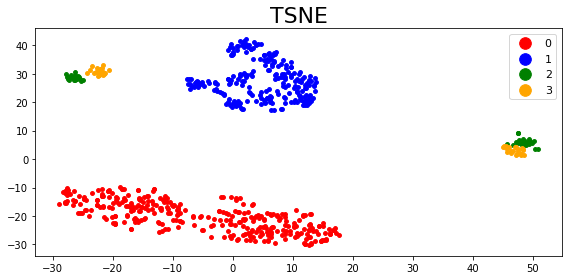

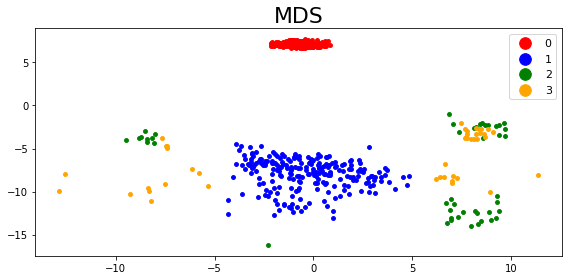

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



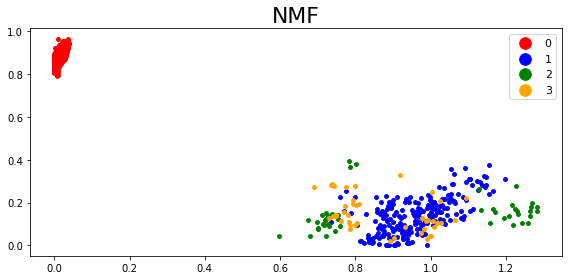

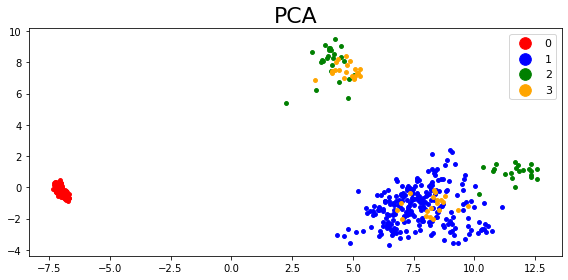

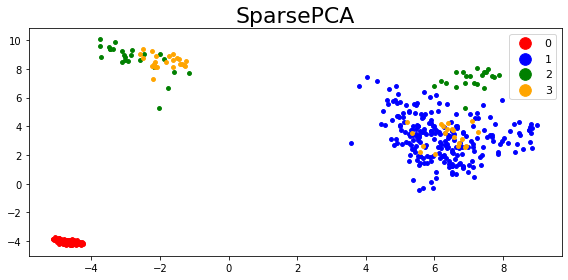

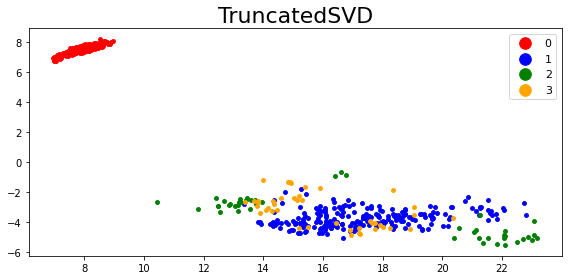

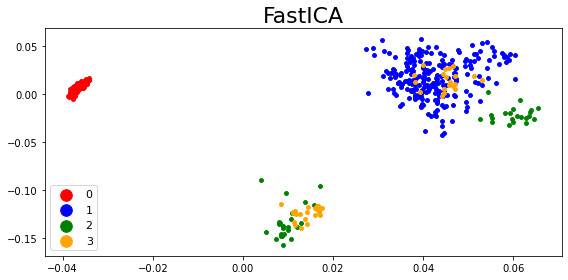

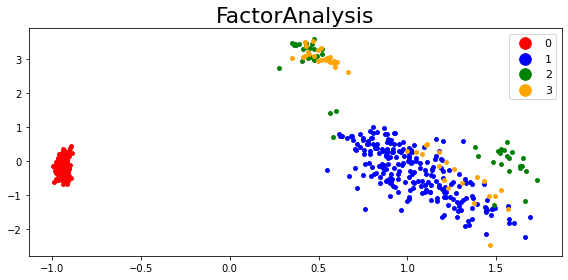

In [38]:
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA, NMF, SparsePCA, TruncatedSVD, FastICA, FactorAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline


# random_state = 42
cdict = {0: 'red',1: 'blue', 2: 'green', 3: 'orange'}

def plot_destribution(X_embedded, y, titleName):
    fig, ax = plt.subplots(figsize=(8,4))
    for iy in np.unique(y):
        ix = np.where(y == iy)
        x1data = X_embedded[:, 0]
        x2data = X_embedded[:, 1]
        ax.scatter(x1data[ix], x2data[ix], c = cdict[iy], label = str(int(iy)), s = 15)
    ax.legend(fontsize=11, markerscale=3)
    ax.set_title(titleName, size=22)
    plt.tight_layout()
    plt.show()  

# sklearn.manifold:
X_tsne = TSNE(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_tsne, y[:, 0], 'TSNE')

X_pca = MDS(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 0], 'MDS')

# sklearn.decomposition
X_pca = NMF(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 0], 'NMF')

X_pca = PCA(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 0], 'PCA')

X_pca = SparsePCA(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 0], 'SparsePCA')

X_pca = TruncatedSVD(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 0], 'TruncatedSVD')

X_pca = FastICA(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 0], 'FastICA')

X_pca = FactorAnalysis(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 0], 'FactorAnalysis')

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



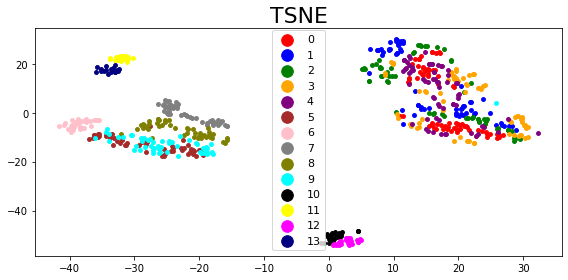

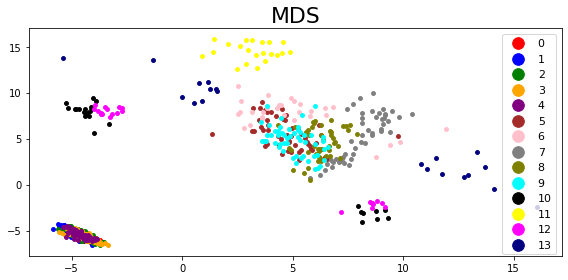

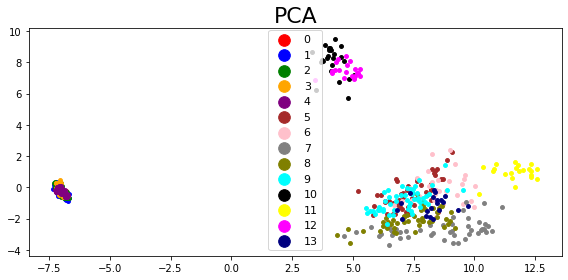

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



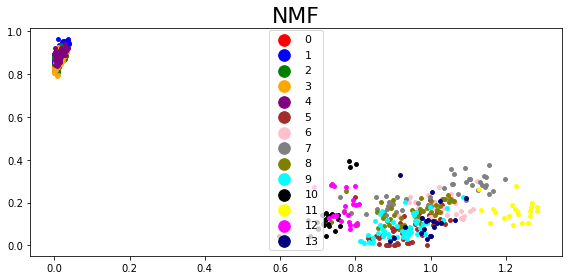

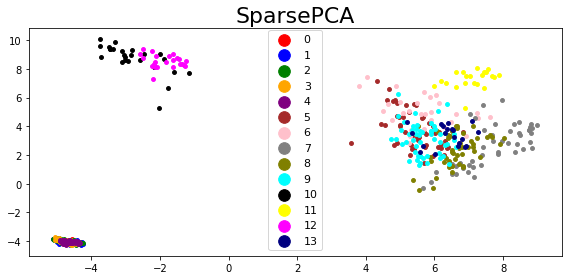

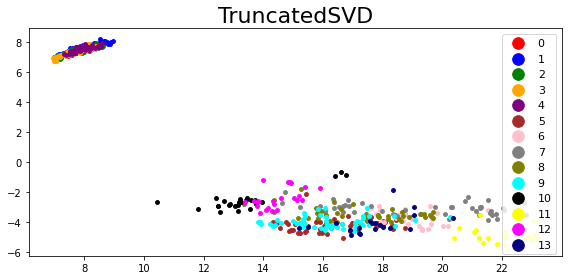

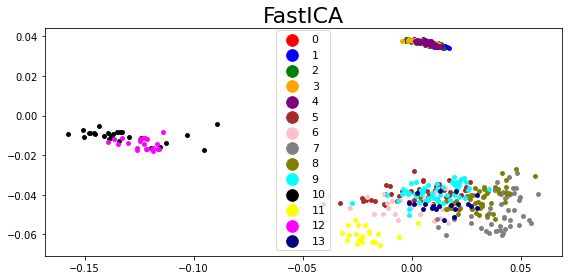

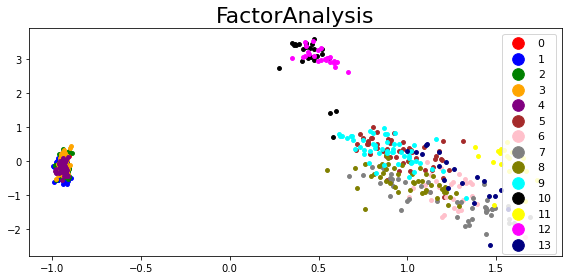

In [39]:
cdict = {
    0: 'red',
    1: 'blue', 
    2: 'green', 
    3: 'orange',
    4: 'purple',
    5: 'brown',
    6: 'pink',
    7: 'gray',
    8: 'olive',
    9: 'cyan',
    10: 'black',
    11: 'yellow',
    12: 'fuchsia',
    13: 'navy' 
    }

# sklearn.manifold:
X_tsne = TSNE(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_tsne, y[:, 1], 'TSNE')

X_pca = MDS(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 1], 'MDS')

# sklearn.decomposition
X_pca = PCA(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 1], 'PCA')

X_pca = NMF(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 1], 'NMF')

X_pca = SparsePCA(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 1], 'SparsePCA')

X_pca = TruncatedSVD(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 1], 'TruncatedSVD')

X_pca = FastICA(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 1], 'FastICA')

X_pca = FactorAnalysis(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 1], 'FactorAnalysis')

### CNN aproach

In [40]:
def make_features(model, X):
    result = []
    data_loader = DataLoader(
        torch.tensor(X).float(), 
        batch_size=16, 
        shuffle=True
    )
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            # print(data.shape)
            # print(model.get_features(data).shape)
            result.append(model.get_features(data))
    return torch.cat(result, dim=0).numpy()

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



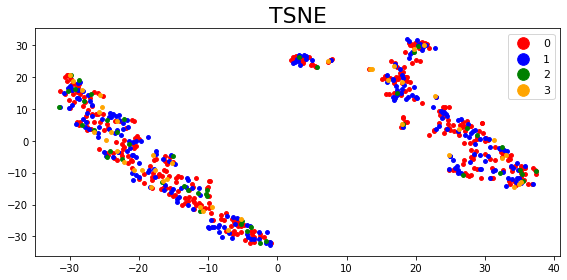

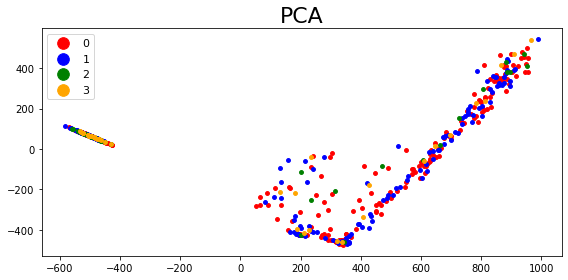

In [42]:
cdict = {
    0: 'red',
    1: 'blue', 
    2: 'green', 
    3: 'orange',
    }

X_features = make_features(model, X)

X_tsne = TSNE(n_components=2).fit_transform(X_features)
plot_destribution(X_tsne, y[:, 0], 'TSNE')

X_pca = PCA(n_components=2).fit_transform(X_features)
plot_destribution(X_pca, y[:, 0], 'PCA')